In [1]:
import os
import time
import random
import argparse
import numpy as np
import scipy.io as sio
import matplotlib as mpl
import torch.utils.data as Data
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


import torch
import torch.nn as nn
from torch import optim
import torch.utils.data as Data
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix


from data_prepare import mirror_hsi
from data_prepare import choose_train_and_test
from data_prepare import choose_all_pixels, all_data
from data_prepare import train_and_test_data, train_and_test_label


from Utils import train, test, valid
from Utils import output_metric, plot_confusion_matrix
from Utils import list_to_colormap, classification_map, print_args
from capsvit import CapsViT, Margin_Recon_Loss


%matplotlib inline

In [2]:
parser = argparse.ArgumentParser("Caps-ViT")
parser.add_argument('--dataset', choices=['LongKou', 'HanChuan', 'HongHu', 'Pavia'], default='Pavia', help='dataset to use')
parser.add_argument('--seed', type=int, default=42, help='number of seed')
parser.add_argument('--batch_size', type=int, default=30, help='number of batch size')
parser.add_argument('--patch_size', type=int, default=15, help='size of patches')
parser.add_argument('--epoches', type=int, default=100, help='epoch number')
parser.add_argument('--learning_rate', type=float, default=1e-3, help='learning rate')
parser.add_argument('--gamma', type=float, default=0.99, help='gamma')
parser.add_argument('--weight_decay', type=float, default=0.001, help='weight_decay')
parser.add_argument('--train_number', type=int, default=25, help='num_train_per_class')
args = parser.parse_args(args=[])

In [3]:
# prepare data
data_path = os.path.join(os.getcwd(), 'dataset')

if args.dataset == 'LongKou':
    data = sio.loadmat(os.path.join(data_path, 'WHU_Hi_LongKou.mat'))['WHU_Hi_LongKou']
    label = sio.loadmat(os.path.join(data_path, 'WHU_Hi_LongKou_gt.mat'))['WHU_Hi_LongKou_gt']
elif args.dataset == 'Pavia':
    data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
    label = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
else:
    raise ValueError("Unknown dataset")
    
num_classes = np.max(label)
print('The class numbers of the HSI data is:', num_classes)

The class numbers of the HSI data is: 9


In [4]:
shapeor = data.shape
data = data.reshape(np.prod(data.shape[:2]), np.prod(data.shape[2:]))

std_scaler = StandardScaler()
std_data = std_scaler.fit_transform(data)
data = std_data.reshape(shapeor)

In [5]:
def applyPCA(data, numComponents=30):
    new_data = np.reshape(data, (-1, data.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    new_data = pca.fit_transform(new_data)
    new_data = np.reshape(new_data, (data.shape[0], data.shape[1], numComponents))
    return new_data, pca

In [6]:
K = 30
data, pca = applyPCA(data, numComponents=K)

# data size
height, width, band = data.shape
print("height={0}, width={1}, band={2}".format(height, width, band))

height=610, width=340, band=30


## Dataloader Construction

In [7]:
mirror_data = mirror_hsi(height, width, band, data, patch_size=args.patch_size)

*******************************************************
patch_size : 15
mirror_data shape : [624, 354, 30]
*******************************************************


In [8]:
total_pos_train, total_pos_test, total_pos_valid, number_train, number_test, number_valid = choose_train_and_test(label, args.train_number, args.seed) 

x_train, x_test, x_valid = train_and_test_data(mirror_data, band, total_pos_train, total_pos_test, total_pos_valid, args.patch_size)
y_train, y_test, y_valid = train_and_test_label(number_train, number_test, number_valid, num_classes)

*******************************************************
x_train shape = (225, 15, 15, 30), type = float64
x_test  shape = (42551, 15, 15, 30), type = float64
x_valid  shape = (900, 15, 15, 30), type = float64
*******************************************************
y_train: shape = (225,), type = int64
y_test: shape = (42551,), type = int64
y_valid: shape = (900,), type = int64
*******************************************************


In [9]:
total_pos_train[:10]

array([[409, 293],
       [404, 298],
       [380, 301],
       [551,  14],
       [453, 165],
       [140, 172],
       [471, 169],
       [175, 187],
       [482, 185],
       [214, 200]])

In [10]:
# load data
x_train = torch.from_numpy(x_train.transpose(0, 3, 1, 2)).type(torch.FloatTensor)  # (90, 1, 7, 7, 176)
print(x_train.shape)
y_train = torch.from_numpy(y_train).type(torch.LongTensor)  # (13,)
train_label = Data.TensorDataset(x_train, y_train)

x_test = torch.from_numpy(x_test.transpose(0, 3, 1, 2)).type(torch.FloatTensor)  # (5198, 1, 7, 7, 176)
print(x_test.shape)
y_test = torch.from_numpy(y_test).type(torch.LongTensor)  # (5198,)
test_label = Data.TensorDataset(x_test, y_test)

x_valid = torch.from_numpy(x_valid.transpose(0, 3, 1, 2)).type(torch.FloatTensor)  # (5211, 1, 7, 7, 176)
print(x_valid.shape)
y_valid = torch.from_numpy(y_valid).type(torch.LongTensor)
valid_label = Data.TensorDataset(x_valid, y_valid)

train_loader = Data.DataLoader(train_label, batch_size=30, shuffle=True)
test_loader = Data.DataLoader(test_label, batch_size=128, shuffle=True)
valid_loader = Data.DataLoader(valid_label, batch_size=64, shuffle=True)

torch.Size([225, 30, 15, 15])
torch.Size([42551, 30, 15, 15])
torch.Size([900, 30, 15, 15])


## Model

In [11]:
model = CapsViT(band, caps2_caps=num_classes)

model = model.cuda()
# criterion
criterion = Margin_Recon_Loss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=args.gamma)

In [12]:
print('start training')
acc_list = [0.00]
path = './model/capsvit.pt'
tic = time.time()
for epoch in range(args.epoches):
    # 计算的是移动平均准确率
    train_acc, train_loss = train(model, train_loader, criterion, optimizer)
    valid_acc, valid_loss = valid(model, valid_loader, criterion)
    print("Epoch: {:03d} - train_loss: {:.4f} - train_acc: {:.4f} - valid_loss: {:.4f} - valid_acc: {:.4f}".\
          format(epoch+1, train_loss, train_acc, valid_loss, valid_acc))
    scheduler.step()

    acc_list.append(valid_acc)
    if acc_list[-1] > acc_list[-2]:
        print("val_acc improved from {:.4f} to {:.4f}, saving model to capsvit.pt".format(acc_list[-2], acc_list[-1]))
        torch.save(model.state_dict(), path)
    else:
        print("val_acc did not improve from {:.4f}".format(acc_list[-2]))
        acc_list[-1] = acc_list[-2]

toc = time.time()
print("Running Time: {:.2f}".format(toc-tic))
print("**************************************************")

start training
Epoch: 001 - train_loss: 0.6081 - train_acc: 10.6667 - valid_loss: 0.5107 - valid_acc: 22.2222
val_acc improved from 0.0000 to 22.2222, saving model to capsvit.pt
Epoch: 002 - train_loss: 0.4540 - train_acc: 34.6667 - valid_loss: 0.3867 - valid_acc: 45.0000
val_acc improved from 22.2222 to 45.0000, saving model to capsvit.pt
Epoch: 003 - train_loss: 0.3437 - train_acc: 49.3333 - valid_loss: 0.2756 - valid_acc: 72.7778
val_acc improved from 45.0000 to 72.7778, saving model to capsvit.pt
Epoch: 004 - train_loss: 0.2663 - train_acc: 62.2222 - valid_loss: 0.2196 - valid_acc: 67.1111
val_acc did not improve from 72.7778
Epoch: 005 - train_loss: 0.2094 - train_acc: 76.8889 - valid_loss: 0.1889 - valid_acc: 70.3333
val_acc did not improve from 72.7778
Epoch: 006 - train_loss: 0.1881 - train_acc: 72.4444 - valid_loss: 0.1753 - valid_acc: 77.6667
val_acc improved from 72.7778 to 77.6667, saving model to capsvit.pt
Epoch: 007 - train_loss: 0.1704 - train_acc: 73.3333 - valid_loss:

In [13]:
model.load_state_dict(torch.load(path))
model.eval()

tar_test, pre_test = test(model, test_loader)
OA_test, AA_mean_test, Kappa_test, AA_test = output_metric(tar_test, pre_test)
AA_test = np.around(AA_test*100, 2)

In [14]:
print("*******************************************************************")
print("Final result:")
print("OA: {:.2f}, AA: {:.2f}, Kappa: {:.4f}".format(OA_test * 100., AA_mean_test*100., Kappa_test))
print("*******************************************************************")
print("Recal: {}".format(AA_test))
print("*******************************************************************")
print("Parameter:")
print_args(vars(args))
print("*******************************************************************")

*******************************************************************
Final result:
OA: 96.95, AA: 96.58, Kappa: 0.9597
*******************************************************************
Recal: [ 91.73  99.03  89.01  97.2  100.   100.   100.    93.25  99.02]
*******************************************************************
Parameter:
dataset: Pavia
seed: 42
batch_size: 30
patch_size: 15
epoches: 100
learning_rate: 0.001
gamma: 0.99
weight_decay: 0.001
train_number: 25
*******************************************************************


In [ ]:
average_accuracy = str(list(AA_test))
file_name = "./CR/capsvit_1.txt"

with open(file_name, 'w') as x_file:
    x_file.write("[{:.2f}, {:.2f}, {:.4f}]".format(OA_test * 100., AA_mean_test*100., Kappa_test))
    x_file.write('\n')
    x_file.write('{}'.format(average_accuracy))

## Panoramic Classification

In [15]:
pos_forward, pos_backward = choose_all_pixels(label)

x_forward, x_backward, y_forward, y_backward = all_data(mirror_data, band, pos_forward, pos_backward, patch_size=args.patch_size)

*******************************************************
x_forward shape = (42776, 15, 15, 30), type = float64
x_backward  shape = (164624, 15, 15, 30), type = float64
*******************************************************


In [16]:
# load data
x_forward = torch.from_numpy(x_forward.transpose(0, 3, 1, 2)).type(torch.FloatTensor)
print(x_forward.shape)
y_forward = torch.from_numpy(y_forward).type(torch.LongTensor)  # (13,)
forward_label = Data.TensorDataset(x_forward, y_forward)

x_backward = torch.from_numpy(x_backward.transpose(0, 3, 1, 2)).type(torch.FloatTensor)
print(x_backward.shape)
y_backward = torch.from_numpy(y_backward).type(torch.LongTensor)  # (13,)
backward_label = Data.TensorDataset(x_backward, y_backward)

forward_loader = Data.DataLoader(forward_label, batch_size=128, shuffle=False)
backward_loader = Data.DataLoader(backward_label, batch_size=128, shuffle=False)

torch.Size([42776, 30, 15, 15])
torch.Size([164624, 30, 15, 15])


In [17]:
# output classification maps
_, pre_forward = test(model, forward_loader)
_, pre_backward = test(model, backward_loader)

prediction_matrix = np.zeros((height, width), dtype=float)  # (512, 614)
for i in range(pos_forward.shape[0]):
    prediction_matrix[pos_forward[i, 0], pos_forward[i, 1]] = pre_forward[i] + 1

for j in range(pos_backward.shape[0]):
    prediction_matrix[pos_backward[j, 0], pos_backward[j, 1]] = pre_backward[j] + 1

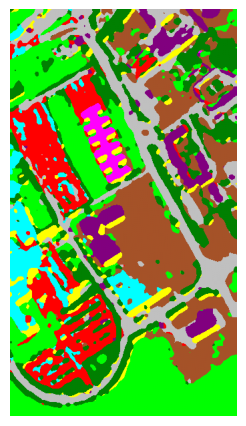

In [18]:
predict_map = list_to_colormap(prediction_matrix.ravel())
predict_map = np.reshape(predict_map, (height, width, 3))

classification_map(predict_map, './pavia_capsvit.pdf')